In [1]:
# try:
#     from google.colab import drive
#     drive.mount('/content/drive')
#     import os
#     os.chdir('/content/drive/MyDrive/Colab Notebooks/PythonWorkSpace/Years/2025/GraphLearning/GroupProject')
# except: pass
from libs.basic import *
pd.set_option("display.max_columns", 100)
PATH_DATA = './data/00.01'
RANDOM_SEED =0
np.random.seed(RANDOM_SEED)  

Using device: cuda


In [2]:
def zip_file_list(path):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
    return file_list
def read_zip_csv(zip_path, csv_name):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open(csv_name) as file:
            return pd.read_csv(file)
def add_eta_phi_rows(df):
    """
    Add eta and phi columns to the DataFrame. Eta is the pseudorapidity and phi is the azimuthal angle.
    """
    df["r_xy"] = np.sqrt(df["x"]**2 + df["y"]**2)
    # df["theta"] = np.arctan2(df["r_xy"], df["z"]) # defined between 0 and pi
    df["theta"] = np.abs(np.arctan(df["r_xy"]/df["z"])) # defined between 0 and pi
    df["log_arg"] = np.tan(df["theta"]) / 2

    df["eta"] = - np.log(df["log_arg"])
    df["eta"] = df["eta"].clip(lower=0) * np.sign(df["z"])
    df["phi"] = np.arctan2(df["y"], df["x"])
    return df


In [3]:
CELLS_DTYPES = dict([
    ('hit_id', 'i4'),
    ('ch0', 'i4'),
    ('ch1', 'i4'),
    ('value', 'f4'),
])
HITS_DTYPES = dict([
    ('hit_id', 'i4'),
    ('x', 'f4'),
    ('y', 'f4'),
    ('z','f4'),
    ('volume_id', 'i4'),
    ('layer_id', 'i4'),
    ('module_id', 'i4'),
])
PARTICLES_DTYPES = dict([
    ('particle_id', 'i8'),
    ('particle_type', 'i4'),
    ('vx', 'f4'),
    ('vy', 'f4'),
    ('vz', 'f4'),
    ('px', 'f4'),
    ('py', 'f4'),
    ('pz', 'f4'),
    ('q', 'i4'),
    ('nhits', 'i4'),
])
TRUTH_DTYPES = dict([
    ('hit_id', 'i4'),
    ('particle_id', 'i8'),
    ('tx', 'f4'),
    ('ty', 'f4'),
    ('tz', 'f4'),
    ('tpx', 'f4'),
    ('tpy', 'f4'),
    ('tpz', 'f4'),
    ('weight', 'f4'),
])
DTYPES = {
    'cells': CELLS_DTYPES,
    'hits': HITS_DTYPES,
    'particles': PARTICLES_DTYPES,
    'truth': TRUTH_DTYPES,
}

# Check the file list in the zip file

In [4]:
zip_file_list(os.path.join(PATH_DATA, 'trackml-particle-identification.zip'))

# Uncompress the outer zip

In [5]:
with zipfile.ZipFile(os.path.join(PATH_DATA, 'trackml-particle-identification.zip'), 'r') as zip_ref:
    os.makedirs(os.path.join(PATH_DATA, 'trackml-particle-identification'), exist_ok = True)
    zip_ref.extractall(os.path.join(PATH_DATA, 'trackml-particle-identification'))

# Covert all CSVs to Parquets

In [6]:
import os
import zipfile
import pandas as pd
from tqdm import tqdm
from glob import glob
from joblib import Parallel, delayed

def process_zip(zip_path):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            csv_names = [i for i in zip_file_list(zip_path) if '.csv' in i]
            for csv_name in tqdm(csv_names, desc = os.path.split(zip_path)[-1]):
                path = os.path.join(
                    zip_path.replace('.zip', ''), 
                    csv_name.replace('.csv', '.parquet')
                ).replace('trackml-particle-identification', 'trackml')
                if not os.path.exists(path):
                    os.makedirs(os.path.split(path)[0], exist_ok=True)
    
                    with zip_ref.open(csv_name) as file:
                        dtype = (
                            DTYPES['cells'] if 'cells' in path else
                            DTYPES['hits'] if 'hits' in path else
                            DTYPES['particles'] if 'particles' in path else
                            DTYPES['truth'] if 'truth' in path else
                            None
                        )
                        df = pd.read_csv(file, dtype=dtype)
                        df.to_parquet(path)
    except Exception as e:
        print(f"Failed to process {zip_path}: {e}")

# Get zip file list
zip_paths = glob(os.path.join(PATH_DATA, 'trackml-particle-identification', '*.zip'))

Parallel(n_jobs=10)(
    delayed(process_zip)(zip_path) for zip_path in tqdm(zip_paths)
)
# Parallel(n_jobs=1)(
#     delayed(process_zip)(zip_path) for zip_path in tqdm(['./data/00.01\\trackml-particle-identification\\train_2.zip'])
# )


# Filtered Truth-Hits in the Cylinderical Coordinate System

In [7]:
def add_eta_phi_rows(df):
    """
    Add eta and phi columns to the DataFrame. Eta is the pseudorapidity and phi is the azimuthal angle.
    """
    df["r_xy"] = np.sqrt(df["x"]**2 + df["y"]**2)
    df["r"] = np.sqrt(df["x"]**2 + df["y"]**2 + df["z"]**2)
    # Alternate calculation: eta = 0.5 * ln((r + z) / (r - z))
    df["eta"] = 0.5 * np.log((df["r"] + df["z"]) / (df["r"] - df["z"]))
    df["phi"] = np.arctan2(df["y"], df["x"]) # [-pi, pi]
    return df
    
# def pT_filter(hits_df, truth_df, pT_min=2):
#     # Apply truth pT filter to hits_df and truth_df. Exclude hits with pT < pt_min
#     mask = truth_df["pT"] > pT_min
#     return hits_df[mask].copy(), truth_df[mask].copy()
def noise_filter(hits_df, truth_df):
    """
    Remove hits not associated with any track in the truth DataFrame.
    Returns filtered hits_df and truth_df with matching rows.
    """
    # In the TrackML dataset, these events will always have particle_id == 0 in truth_df
    mask = truth_df["particle_id"] != 0
    return hits_df[mask].copy(), truth_df[mask].copy()
def add_pT(truth_df):
    """
    Add transverse momentum (pT) columns to truth DataFrame.
    """
    truth_df["pT"] = np.sqrt(truth_df["tpx"]**2 + truth_df["tpy"]**2)
    return truth_df


truth_paths = [i for i in glob(os.path.join(PATH_DATA,'trackml','train_*','train_*','*-truth.parquet')) if 'train_sample' not in i]
truth_paths = pd.Series({int(os.path.split(i)[-1][5:14]): i for i in truth_paths}).sort_index()
hits_paths = [i for i in glob(os.path.join(PATH_DATA,'trackml','train_*','train_*','*-hits.parquet')) if 'train_sample' not in i]
hits_paths = pd.Series({int(os.path.split(i)[-1][5:14]): i for i in hits_paths}).sort_index()
paths = pd.concat([truth_paths, hits_paths], axis =1 , keys = ['truth','hits'])
paths.index.name = 'event'

In [8]:
zero_removal = True
pT_min = 2.0

def f(e,t,h, zero_removal, pT_min):
    t = add_pT(pd.read_parquet(t))
    if zero_removal:
        t = t[t['particle_id']!=0]
    t = t[t['pT']>pT_min]
    ht = pd.merge(pd.read_parquet(h), t, on = 'hit_id', how = 'right')
    ht['event'] = np.int32(e)
    return ht
# hts = [f(e,t,h, zero_removal, pT_min) for e, t, h in tqdm(paths.sort_index().reset_index().values)]
for zero_removal in tqdm([True
                          # , False
                         ]):
    for pT_min in tqdm([2.0
                        # ,1.5,1.0,0.5,0.0
                       ]):
        hts = pd.concat(Parallel(n_jobs = 24)(delayed(f) (e,t,h, zero_removal, pT_min) 
                                              for e, t, h in tqdm(paths.sort_index().reset_index().values))).reset_index(drop = True)
        hts= add_eta_phi_rows(hts)#.drop(['x','y','z'], axis = 1)
        os.makedirs(os.path.join(PATH_DATA,'trackml','truth_hits'), exist_ok=True)
        hts.to_parquet(os.path.join(PATH_DATA,'trackml','truth_hits',f'truth_hits_{"filtered" if zero_removal else "unfiltered"}_pT_gt_{pT_min}.parquet'))

# Blacklist CSV

In [9]:
blacklist_hits = pd.concat({int(os.path.split(p)[-1].split('-')[0].replace('event','')):pd.read_parquet(p) for p in 
                                tqdm(glob(os.path.join(PATH_DATA,'trackml','blacklist_training','*hits.parquet')))})
blacklist_particles = pd.concat({int(os.path.split(p)[-1].split('-')[0].replace('event','')):pd.read_parquet(p) for p in 
                                tqdm(glob(os.path.join(PATH_DATA,'trackml','blacklist_training','*particles.parquet')))})
blacklist_hits= blacklist_hits.reset_index(level =1, drop = True)
blacklist_hits.index.name = 'event'
blacklist_hits = blacklist_hits.reset_index()
blacklist_particles= blacklist_particles.reset_index(level =1, drop = True)
blacklist_particles.index.name = 'event'
blacklist_particles = blacklist_particles.reset_index()
blacklist_hits.to_parquet(os.path.join(PATH_DATA,'trackml','blacklist_training','blacklist_hits.parquet'))
blacklist_particles.to_parquet(os.path.join(PATH_DATA,'trackml','blacklist_training','blacklist_particles.parquet'))

# Graph Construction

In [10]:
zero_removal = True
pT_min = 2.0
path = os.path.join(PATH_DATA,'trackml','truth_hits',f'truth_hits_{"filtered" if zero_removal else "unfiltered"}_pT_gt_{pT_min}.parquet')
hts = pd.read_parquet(path).set_index(['event','hit_id'])#[['particle_id','x','y','z','r','eta','phi','r_xy']]
blacklist_hits = pd.read_parquet(os.path.join(PATH_DATA,'trackml','blacklist_training','blacklist_hits.parquet'))
blacklist_particles = pd.read_parquet(os.path.join(PATH_DATA,'trackml','blacklist_training','blacklist_particles.parquet'))
hts = hts.drop(blacklist_hits.set_index(['event','hit_id']).index.intersection(hts.index), errors='ignore')
hts = hts.reset_index().set_index(['event','particle_id'])
hts = hts.drop(hts.index.intersection(blacklist_particles.set_index(['event','particle_id']).index))
hts = hts.reset_index().set_index(['event','hit_id'])

## Split the Data

In [11]:
from sklearn.model_selection import train_test_split
np.random.seed(RANDOM_SEED)  
events_train, events_test = train_test_split(np.sort(hts.reset_index()['event'].unique()), test_size=0.2, random_state=RANDOM_SEED)
events_train, events_val = train_test_split(events_train, test_size=0.2, random_state=RANDOM_SEED)
hts_train, hts_val, hts_test = hts.loc[np.sort(events_train)], hts.loc[np.sort(events_val)], hts.loc[np.sort(events_test)]

## Link Probability Estimation

In [12]:
def delta_phi(phi1, phi2):
    delta_phi = phi2-phi1
    return np.arctan2(np.sin(delta_phi), np.cos(delta_phi))  
class CustomKNN(BaseEstimator, RegressorMixin):
    def __init__(self, n_neighbors,ratio = 0.01,chunk_size=5000,n_jobs = 1, **kwargs):
        self.ratio = ratio
        self.chunk_size = chunk_size
        self.n_jobs= n_jobs
        self.scaler = StandardScaler()
        self.knn =KNeighborsRegressor(n_neighbors=n_neighbors, **kwargs)

    def fit(self, X, y):
       # Input validation
        self.X_=X.values if isinstance(X, pd.DataFrame) else X
        self.scaler = self.scaler.fit(X)
        self.X_ = self.scaler.transform(X)
        self.y_ = y.values.astype(float) if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series)  else y.astype(float)
        self.minX = self.X_[self.y_>0.5].min(axis=0)
        self.maxX = self.X_[self.y_>0.5].max(axis=0)
        r = self.maxX-self.minX
        self.minX= self.minX-r*self.ratio
        self.maxX =self.maxX+r*self.ratio

        f1 = (self.X_>=self.minX).all(axis = 1)
        f2 = (self.X_<=self.maxX).all(axis = 1)
        f = f1&f2

        self.knn = self.knn.fit(self.X_[f],self.y_[f])
        return self

    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)
        # Input validation
        X_=X.values if isinstance(X, pd.DataFrame) else X
        X_ = self.scaler.transform(X_)
        f1 = (X_>=self.minX).all(axis = 1)
        f2 = (X_<=self.maxX).all(axis = 1)
        f = f1&f2        
        y_pred = f.astype(float)
        aX = X_[f]
        if self.n_jobs <=1:
            y_pred[f]=np.concatenate([self.knn.predict(aX[i:i+self.chunk_size]) for i in trange(0,aX.shape[0], self.chunk_size, leave = False)])
        else:
            y_pred[f]=np.concatenate(
            Parallel(n_jobs = self.n_jobs)(
            delayed(self.knn.predict)(aX[i:i+self.chunk_size]) for i in trange(0,aX.shape[0], self.chunk_size, leave = False))
                                )
        # y_pred[f]=self.knn.predict(aX)
        
        return y_pred
def preproces(hts):
    link_hts = hts[['event','hit_id','eta','phi','particle_id']]
    Xy = pd.merge(link_hts, link_hts, on = 'event', how = 'outer', suffixes = ['_1','_2'])
    Xy['y']=Xy['particle_id_1']==Xy['particle_id_2']
    Xy['eta_d']=Xy['eta_2']-Xy['eta_1']
    Xy['phi_d']=delta_phi(Xy['phi_1'], Xy['phi_2'])
    return Xy[['event','hit_id_1','hit_id_2','y','eta_d','phi_d']]

### Create Train and Validation dataset for link probability estimation

In [13]:
np.random.seed(RANDOM_SEED)
n_link_events = 10
link_events = np.random.choice(events_train, n_link_events)
link_val_events = np.random.choice(link_events, n_link_events//5)
link_train_events = [i for i in link_events if i not in link_val_events]
link_train = preproces(hts_train.loc[link_train_events].reset_index())
link_val = preproces(hts_train.loc[link_val_events].reset_index())
# link_train.to_parquet('./temp_link_train.parquet')
# link_val.to_parquet('./temp_link_val.parquet')
# from libs.basic import *
# pd.set_option("display.max_columns", 100)
# PATH_DATA = './data/00.01'
# RANDOM_SEED =0
# np.random.seed(RANDOM_SEED)  
# link_train=pd.read_parquet('./temp_link_train.parquet')
# link_val=pd.read_parquet('./temp_link_val.parquet')

features = ['eta_d','phi_d']
scalerX = StandardScaler().fit(link_train[features].values)

In [14]:
trainX = torch.tensor(scalerX.transform(link_train[features].values), dtype=torch.float32).to(device)
trainY = torch.tensor(link_train['y'].values, dtype=torch.float32).to(device)
valX = torch.tensor(scalerX.transform(link_val[features].values), dtype=torch.float32).to(device)
valY = torch.tensor(link_val['y'].values, dtype=torch.float32).to(device)

### Visualization of Probability

In [15]:
temp = link_train[
link_train['eta_d'].between(link_train[link_train['y']]['eta_d'].quantile(0.01),link_train[link_train['y']]['eta_d'].quantile(0.99)
)&link_train['phi_d'].between(link_train[link_train['y']]['phi_d'].quantile(0.01),link_train[link_train['y']]['phi_d'].quantile(0.99))
]

C:\Users\hshan\AppData\Local\Temp\ipykernel_5012\1227427963.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = temp.pivot_table(values='y', index='eta_center', columns='phi_center', aggfunc='mean')


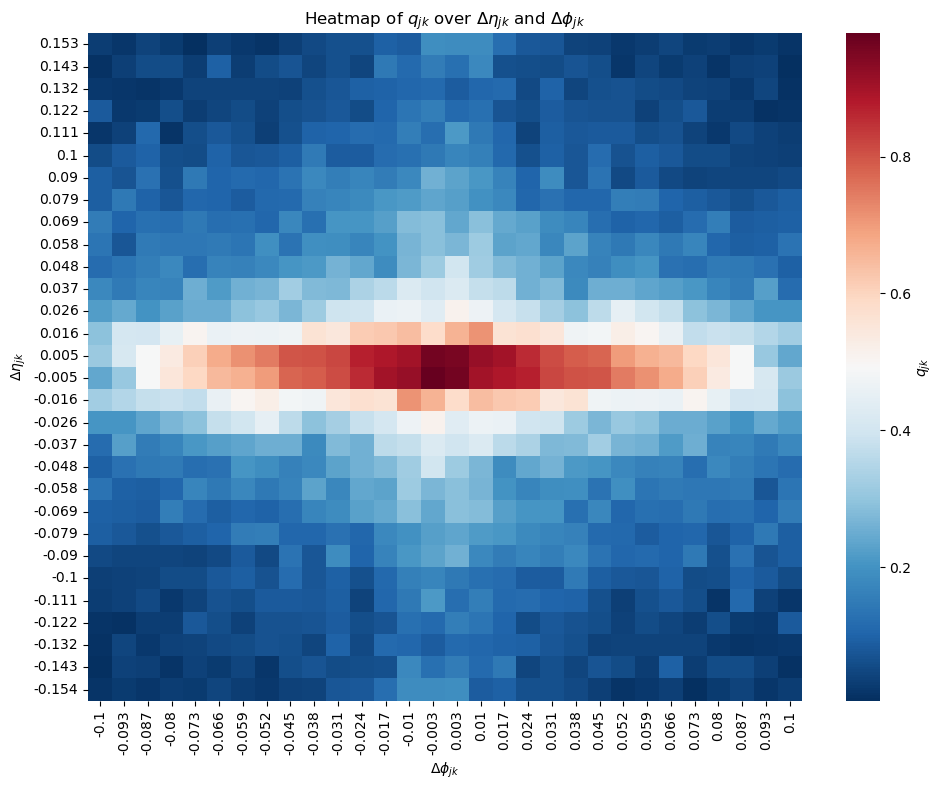

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

eta_bins = 30
phi_bins = 30

# temp 복사 및 bin 중심값 계산
temp = temp.copy()
temp['eta_bin'] = pd.cut(temp['eta_d'], bins=eta_bins)
temp['phi_bin'] = pd.cut(temp['phi_d'], bins=phi_bins)

# 각 bin의 중앙값 계산
temp['eta_center'] = temp['eta_bin'].apply(lambda x: np.round(x.mid,3))
temp['phi_center'] = temp['phi_bin'].apply(lambda x: np.round(x.mid, 3))

# Pivot table for heatmap
pivot_table = temp.pivot_table(values='y', index='eta_center', columns='phi_center', aggfunc='mean')

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table.sort_index(ascending=False),  # y축은 위에서 아래로 가게 뒤집음
            cmap="RdBu_r", 
            cbar_kws={'label': r'$q_{jk}$'})

plt.xlabel(r'$\Delta \phi_{jk}$')
plt.ylabel(r'$\Delta \eta_{jk}$')
plt.title(r'Heatmap of $q_{jk}$ over $\Delta \eta_{jk}$ and $\Delta \phi_{jk}$')
plt.tight_layout()
plt.show()


C:\Users\hshan\AppData\Local\Temp\ipykernel_9616\3025042391.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = temp.groupby([


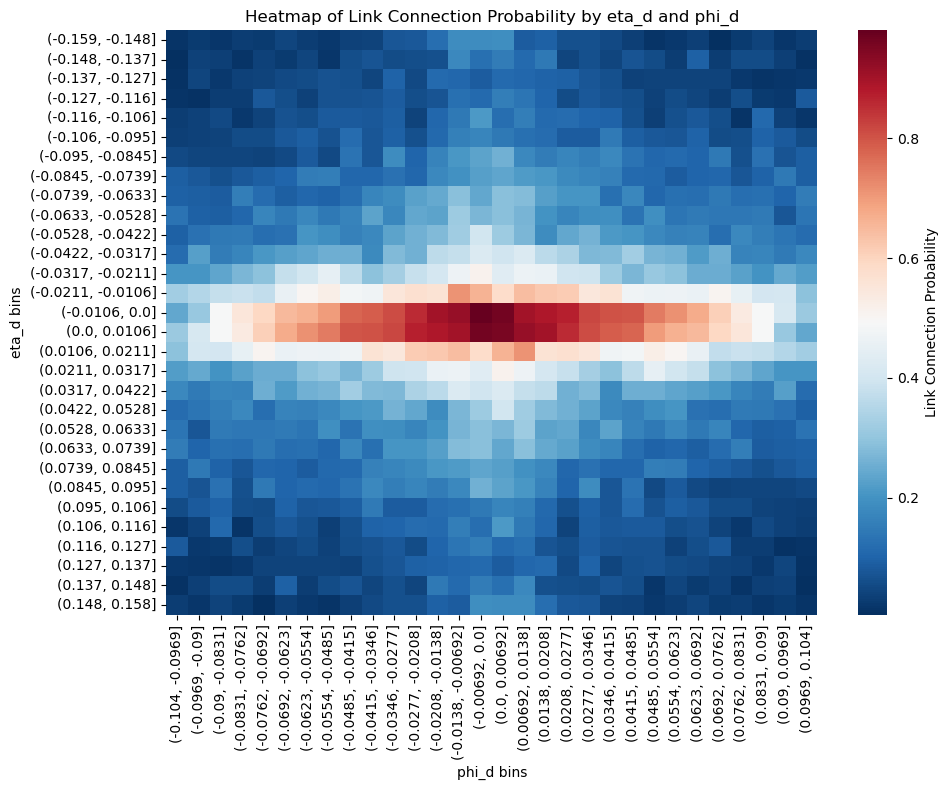

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

eta_bins = 30
phi_bins = 30

heatmap_data = temp.groupby([
    pd.cut(temp['eta_d'], bins=eta_bins),
    pd.cut(temp['phi_d'], bins=phi_bins)
])['y'].mean().unstack()

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="RdBu_r", cbar_kws={'label': 'Link Connection Probability'})
plt.xlabel('phi_d bins')
plt.ylabel('eta_d bins')
plt.title('Heatmap of Link Connection Probability by eta_d and phi_d')
plt.tight_layout()
plt.show()

C:\Users\hshan\AppData\Local\Temp\ipykernel_3884\3025042391.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = temp.groupby([


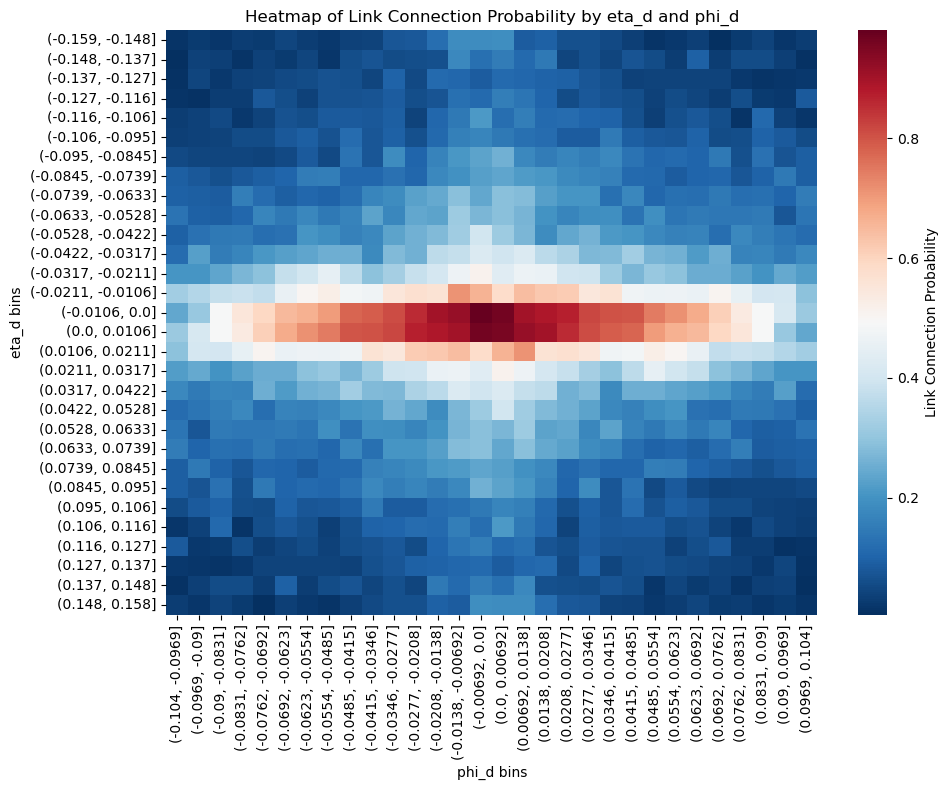

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

eta_bins = 30
phi_bins = 30

heatmap_data = temp.groupby([
    pd.cut(temp['eta_d'], bins=eta_bins),
    pd.cut(temp['phi_d'], bins=phi_bins)
])['y'].mean().unstack()

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="RdBu_r", cbar_kws={'label': 'Link Connection Probability'})
plt.xlabel('phi_d bins')
plt.ylabel('eta_d bins')
plt.title('Heatmap of Link Connection Probability by eta_d and phi_d')
plt.tight_layout()
plt.show()

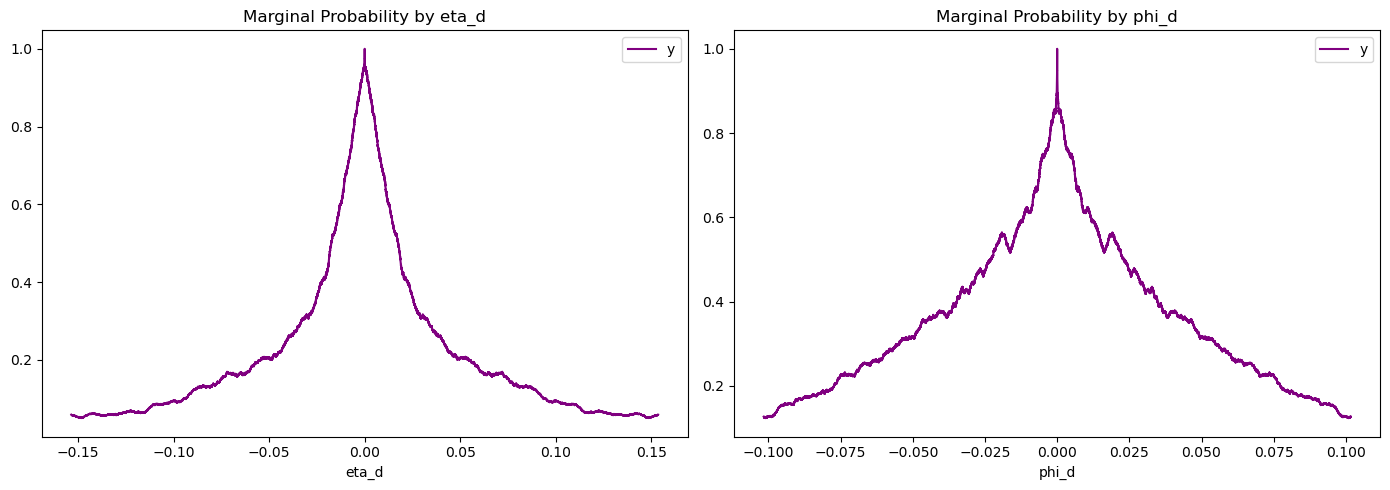

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

temp.sort_values('eta_d')[['y', 'eta_d']] \
    .rolling(len(temp)//100).mean() \
    .shift(-(len(temp)//100)//2) \
    .dropna() \
    .plot(x='eta_d', y='y', ax=axes[0], title='Marginal Probability by eta_d',color = 'purple')

temp.sort_values('phi_d')[['y', 'phi_d']] \
    .rolling(len(temp)//100).mean() \
    .shift(-(len(temp)//100)//2) \
    .dropna() \
    .plot(x='phi_d', y='y', ax=axes[1], title='Marginal Probability by phi_d',color = 'purple')

plt.tight_layout()
plt.show()

### Train a link probability prediction model

In [23]:
class PolynomialRegression(nn.Module):
    def __init__(self, n_vars,l_degree=1, r_degree=3):
        super().__init__()
        self.l_degree, self.r_degree = l_degree, r_degree
        self.n_vars = n_vars
        self.coeffs = nn.Parameter(10*torch.rand(n_vars, r_degree-l_degree+1))  # shape: (n_vars, degree)
        # self.intercept = nn.Parameter(torch.randn(1))

    def forward(self, x):
        # x: (batch_size, n_vars)
        poly_terms = torch.stack([torch.abs(x) ** i  for i in range(self.l_degree, self.r_degree+1)], dim=2)  # shape: (batch_size, n_vars, degree)
        
        out = (poly_terms * self.coeffs).sum(dim=(1, 2))  # scalar output per sample
        return out    
class ProbRegression(nn.Module):
    def __init__(self,):
        super().__init__()
        self.reg = PolynomialRegression(2,1,7)
        
    def forward(self,x):
        return th.exp(-self.reg(x))
# model = ProbRegression(2).to(device)
# model(valX[:3])

In [19]:
model = ProbRegression().to(device)

lr =1.0e0
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

eps = 1.0e-8
train_losses, val_losses, min_val_loss = [],[],np.inf
for step in trange(1000):
    model.train()
    optimizer.zero_grad()
    train_losses.append(F.binary_cross_entropy(model(trainX).clamp(min=eps, max=1 - eps), trainY))
    train_losses[step].backward()
    optimizer.step()
    train_losses[step] = train_losses[step].item()
    model.eval()
    with torch.no_grad():
        preds_val = model(valX)
        val_losses.append(F.binary_cross_entropy(preds_val.clamp(min=eps, max=1 - eps), valY).item())
    if step % 10 ==0:
        if min_val_loss<np.min(val_losses[-10:]):
            lr/=10.
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            print('lr upadate', lr)
            
    if step % 50 == 0:
        print(f"Step {step} - Train Loss: {train_losses[step]} Val Loss: {val_losses[step]}", preds_val.min().item())
        if min_val_loss<np.min(val_losses[-50:]):
            break
        else:
            best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
model.load_state_dict({k: v.to('cuda') for k,v in best_model_state.items()})
torch.save({'model': model,'scalerX':scalerX,'trained_events': link_train_events}, os.path.join(PATH_DATA, 'probability_model.pt'))

  0%|          | 0/1000 [00:00<?, ?it/s]

Step 0 - Train Loss: 0.022626882418990135 Val Loss: 0.015271985903382301 0.0
Step 50 - Train Loss: 0.004154151771217585 Val Loss: 0.003980689682066441 0.0
Step 100 - Train Loss: 0.003951840568333864 Val Loss: 0.003939078189432621 0.0
Step 150 - Train Loss: 0.00389187503606081 Val Loss: 0.00395980104804039 0.0
Step 200 - Train Loss: 0.0038691835943609476 Val Loss: 0.003982492256909609 0.0
Step 250 - Train Loss: 0.003858451498672366 Val Loss: 0.003997290972620249 0.0
Step 300 - Train Loss: 0.0038519022054970264 Val Loss: 0.004005007911473513 0.0
Step 350 - Train Loss: 0.0038471543230116367 Val Loss: 0.004008333198726177 0.0
Step 400 - Train Loss: 0.0038434297312051058 Val Loss: 0.004009438678622246 0.0
Step 450 - Train Loss: 0.0038403889629989862 Val Loss: 0.0040095713920891285 0.0
Step 500 - Train Loss: 0.0038378117606043816 Val Loss: 0.00400927010923624 0.0
Step 550 - Train Loss: 0.003835533047094941 Val Loss: 0.004008686635643244 0.0
Step 600 - Train Loss: 0.0038334308192133904 Val Lo

### Evaluate the model

In [24]:
model = th.load(os.path.join(PATH_DATA, 'probability_model.pt'),weights_only= False)['model']

In [25]:
with torch.no_grad():
    link_train['pred'] = model(trainX).to('cpu').numpy()    

In [26]:
temp = link_train[
link_train['eta_d'].between(link_train[link_train['y']]['eta_d'].quantile(0.01),link_train[link_train['y']]['eta_d'].quantile(0.99)
)&link_train['phi_d'].between(link_train[link_train['y']]['phi_d'].quantile(0.01),link_train[link_train['y']]['phi_d'].quantile(0.99))
]

Text(0.5, 24.140625, '$\\Delta \\eta_{jk}$')

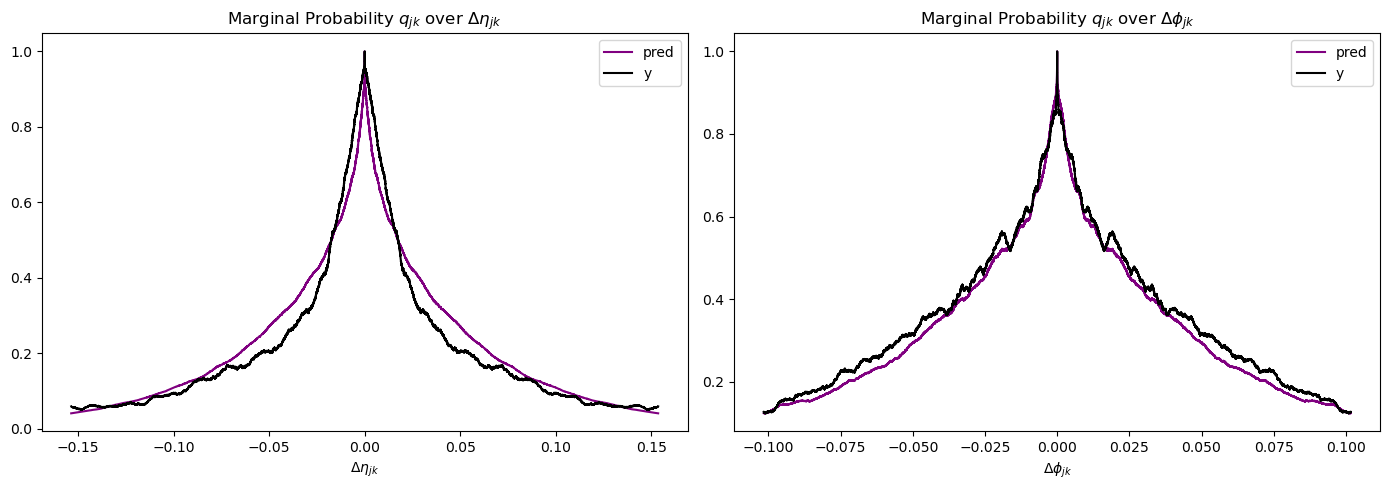

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

temp.sort_values('eta_d')[['pred', 'eta_d']] \
    .rolling(len(temp)//100).mean() \
    .shift(-(len(temp)//100)//2) \
    .dropna() \
    .plot(x=r'eta_d', y='pred', ax=axes[0], title=r'Marginal Probability $q_{jk}$ over $\Delta \eta_{jk}$',color = 'purple')
temp.sort_values('eta_d')[['y', 'eta_d']] \
    .rolling(len(temp)//100).mean() \
    .shift(-(len(temp)//100)//2) \
    .dropna() \
    .plot(x=r'eta_d', y='y', ax=axes[0], title=r'Marginal Probability $q_{jk}$ over $\Delta \eta_{jk}$',color = 'black')

temp.sort_values('phi_d')[['pred', 'phi_d']] \
    .rolling(len(temp)//100).mean() \
    .shift(-(len(temp)//100)//2) \
    .dropna() \
    .plot(x=r'phi_d', y='pred', ax=axes[1], title=r'Marginal Probability $q_{jk}$ over $\Delta \phi_{jk}$',color = 'purple')
temp.sort_values('phi_d')[['y', 'phi_d']] \
    .rolling(len(temp)//100).mean() \
    .shift(-(len(temp)//100)//2) \
    .dropna() \
    .plot(x=r'phi_d', y='y', ax=axes[1], title=r'Marginal Probability $q_{jk}$ over $\Delta \phi_{jk}$',color = 'black')

axes[0].set_xlabel(r'$\Delta \eta_{jk}$')
axes[1].set_xlabel(r'$\Delta \phi_{jk}$')
plt.tight_layout()
plt.show()

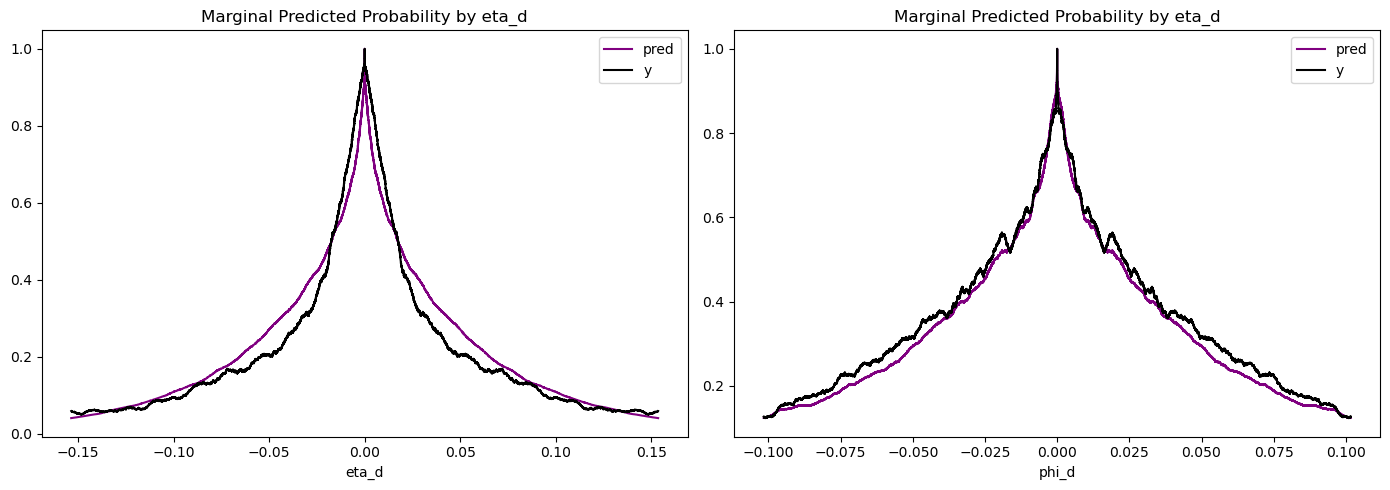

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

temp.sort_values('eta_d')[['pred', 'eta_d']] \
    .rolling(len(temp)//100).mean() \
    .shift(-(len(temp)//100)//2) \
    .dropna() \
    .plot(x='eta_d', y='pred', ax=axes[0], title='Marginal Predicted Probability by eta_d',color = 'purple')
temp.sort_values('eta_d')[['y', 'eta_d']] \
    .rolling(len(temp)//100).mean() \
    .shift(-(len(temp)//100)//2) \
    .dropna() \
    .plot(x='eta_d', y='y', ax=axes[0], title='Marginal Predicted Probability by eta_d',color = 'black')

temp.sort_values('phi_d')[['pred', 'phi_d']] \
    .rolling(len(temp)//100).mean() \
    .shift(-(len(temp)//100)//2) \
    .dropna() \
    .plot(x='phi_d', y='pred', ax=axes[1], title='Marginal Predicted Probability by phi_d',color = 'purple')
temp.sort_values('phi_d')[['y', 'phi_d']] \
    .rolling(len(temp)//100).mean() \
    .shift(-(len(temp)//100)//2) \
    .dropna() \
    .plot(x='phi_d', y='y', ax=axes[1], title='Marginal Predicted Probability by eta_d',color = 'black')
plt.tight_layout()
plt.show()

C:\Users\hshan\AppData\Local\Temp\ipykernel_5012\1224803311.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = temp.pivot_table(values='pred', index='eta_center', columns='phi_center', aggfunc='mean')


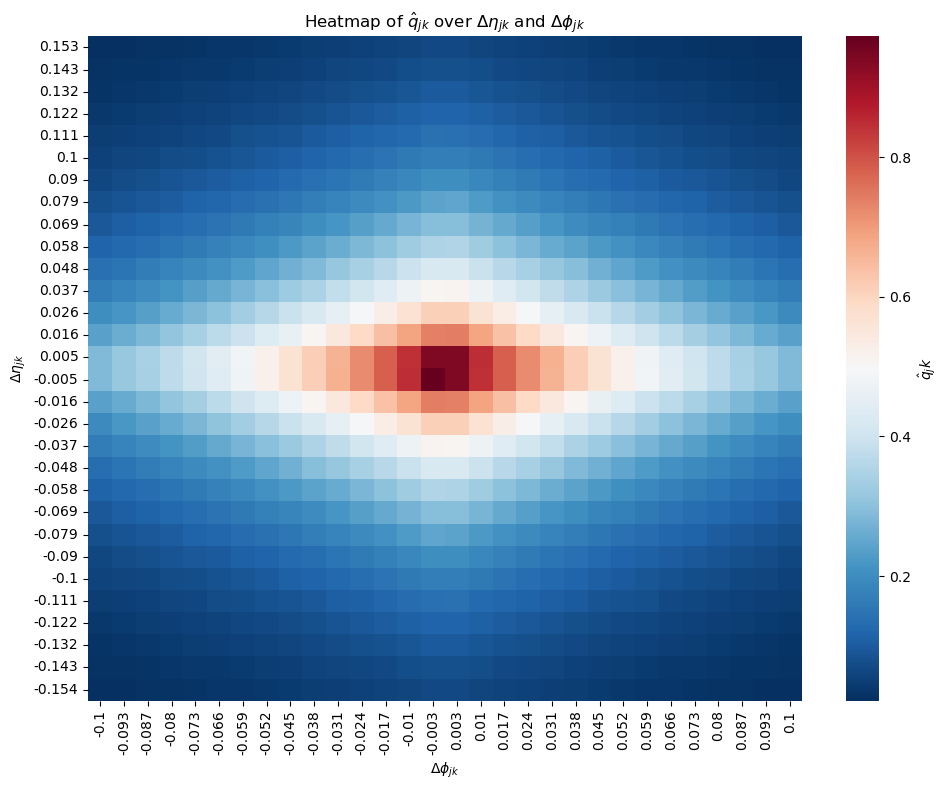

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

eta_bins = 30
phi_bins = 30

# temp 복사 및 bin 중심값 계산
temp = temp.copy()
temp['eta_bin'] = pd.cut(temp['eta_d'], bins=eta_bins)
temp['phi_bin'] = pd.cut(temp['phi_d'], bins=phi_bins)

# 각 bin의 중앙값 계산
temp['eta_center'] = temp['eta_bin'].apply(lambda x: np.round(x.mid,3))
temp['phi_center'] = temp['phi_bin'].apply(lambda x: np.round(x.mid, 3))

# Pivot table for heatmap
pivot_table = temp.pivot_table(values='pred', index='eta_center', columns='phi_center', aggfunc='mean')

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table.sort_index(ascending=False),  # y축은 위에서 아래로 가게 뒤집음
            cmap="RdBu_r", 
            cbar_kws={'label': r'$\hat{q}_jk$'})

plt.xlabel(r'$\Delta \phi_{jk}$')
plt.ylabel(r'$\Delta \eta_{jk}$')
plt.title(r'Heatmap of $\hat{q}_{jk}$ over $\Delta \eta_{jk}$ and $\Delta \phi_{jk}$')
plt.tight_layout()
plt.show()


C:\Users\hshan\AppData\Local\Temp\ipykernel_3884\1544739781.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = temp.groupby([


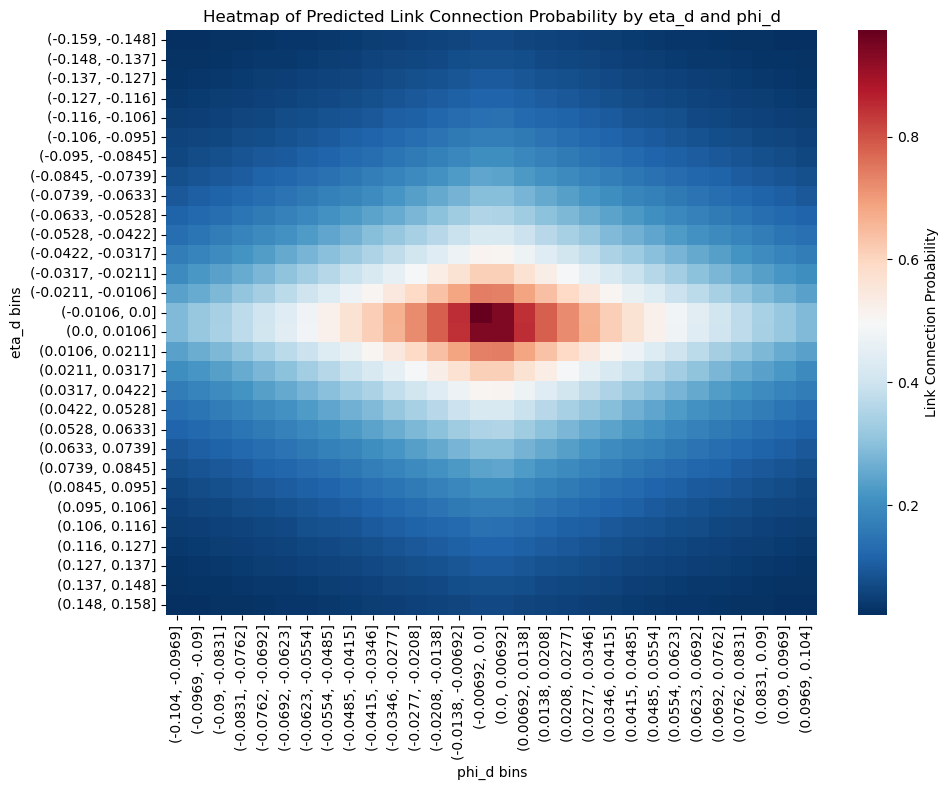

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

eta_bins = 30
phi_bins = 30

heatmap_data = temp.groupby([
    pd.cut(temp['eta_d'], bins=eta_bins),
    pd.cut(temp['phi_d'], bins=phi_bins)
])['pred'].mean().unstack()

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="RdBu_r", cbar_kws={'label': 'Link Connection Probability'})
plt.xlabel('phi_d bins')
plt.ylabel('eta_d bins')
plt.title('Heatmap of Predicted Link Connection Probability by eta_d and phi_d')
plt.tight_layout()
plt.show()

### Link Probabilities

In [7]:
x = torch.load(os.path.join(PATH_DATA, 'probability_model.pt'), weights_only=False)
model,scalerX = x['model'], x['scalerX']
features = ['eta_d','phi_d']

In [11]:
def process_event(event, rows):
    with torch.no_grad():
        links = preproces(rows.reset_index())
        x_tensor=torch.tensor(scalerX.transform(links[features]),dtype = torch.float32).to(device)
        preds = model(x_tensor)
        links['pred'] = preds.cpu().numpy()
        links = links[links['pred']>=1.0e-8]
        links.to_parquet(os.path.join(PATH_DATA, 'link_candidates',str(event)+'.parquet'))
        del x_tensor, preds
        torch.cuda.empty_cache()


Parallel(n_jobs=8)(
    delayed(process_event)(event, rows)
    for event, rows in tqdm(list(hts.groupby('event'))[1000+3000+1500+2000:])
)

  0%|          | 0/1350 [00:00<?, ?it/s]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## Generate Graphs

### Check the ratio (#particles that can be connected by a graph)/(#particles)

In [1]:
%%time
from libs.basic import *
pd.set_option("display.max_columns", 100)
PATH_DATA = './data/00.01'
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

def get_hts():
    zero_removal = True
    pT_min = 2.0
    path = os.path.join(PATH_DATA,'trackml','truth_hits',f'truth_hits_{"filtered" if zero_removal else "unfiltered"}_pT_gt_{pT_min}.parquet')
    hts = pd.read_parquet(path).set_index(['event','hit_id'])#[['particle_id','x','y','z','r','eta','phi','r_xy']]
    blacklist_hits = pd.read_parquet(os.path.join(PATH_DATA,'trackml','blacklist_training','blacklist_hits.parquet'))
    blacklist_particles = pd.read_parquet(os.path.join(PATH_DATA,'trackml','blacklist_training','blacklist_particles.parquet'))
    hts = hts.drop(blacklist_hits.set_index(['event','hit_id']).index.intersection(hts.index), errors='ignore')
    hts = hts.reset_index().set_index(['event','particle_id'])
    hts = hts.drop(hts.index.intersection(blacklist_particles.set_index(['event','particle_id']).index))
    hts = hts.reset_index()[['event','hit_id','particle_id']]
    return hts

hts = get_hts()

Using device: cuda
CPU times: total: 35.9 s
Wall time: 38.4 s


In [2]:
def check_connected(event, ph, deg):
    import warnings
    warnings.filterwarnings('ignore')
    try:
        particle_hits = ph.groupby('particle_id')['hit_id'].apply(lambda x: list(np.unique(x)))
        df = pd.read_parquet(os.path.join(PATH_DATA, 'link_candidates',str(event)+'.parquet'))
        df = df[df['hit_id_1']!=df['hit_id_2']].reset_index(drop = True)
        df =df.groupby('hit_id_1').apply(lambda x: x.loc[x['pred'].nlargest(deg).index]).reset_index(level = -1, drop = True)
        # hit_ids = np.unique(df['hit_id_1'].unique().tolist()+df['hit_id_2'].unique().tolist()).tolist()
        # print(len(df))
        G = nx.Graph()
        G.add_edges_from(df[['hit_id_1','hit_id_2']].values)
        average_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
        n_nodes = G.number_of_nodes()
        connectedness= dict()
        for p, p_hits in particle_hits.items(): 
            if len(p_hits)>1:
                h1 = p_hits[0]
                if h1 not in G:
                    connectedness[(deg,average_degree,n_nodes,event, p)] = False
                    break      
                connectedness[(deg,average_degree,n_nodes,event, p)] = True
                for h2 in p_hits[1:]: 
                    if h2 not in G:
                        connectedness[(deg,average_degree,n_nodes,event, p)] = False
                        break    
                    if not nx.has_path(G, h1, h2):
                        connectedness[(deg,average_degree,n_nodes,event, p)] = False
                        break   
            else:
                connectedness[(deg,average_degree,n_nodes,event, p)] = True
        return pd.Series(connectedness)
    except Exception as e:
        raise Exception(f"{event} {deg} {str(e)}")
        
        
rs = Parallel(n_jobs = 12)(delayed(check_connected)(event, ph, deg)
        for event, ph in tqdm(list(hts.groupby('event'))[:50])
                      for deg in list(range(1, 16))+[20,30,40,50])
rs = pd.concat(rs)
rs.index.names = ['degree','avg_degree', 'n_nodes','event','particle_id']

os.makedirs(os.path.join(PATH_DATA, 'efficiency_degree'), exist_ok = True)
rs.to_pickle(os.path.join(PATH_DATA, 'efficiency_degree','eff_deg_maxProb.pkl'))

rs.groupby(level ='degree').mean()

rs.groupby(level ='degree').mean().plot(
    title = 'When GNN predicts 100% correctly, how much particles can be tracked',
figsize = (15,5))

  0%|          | 0/50 [00:00<?, ?it/s]

ValueError: Length of names must match number of levels in MultiIndex.

<Axes: title={'center': 'When GNN predicts 100% correctly, how much particles can be tracked'}, xlabel='avg_degree'>

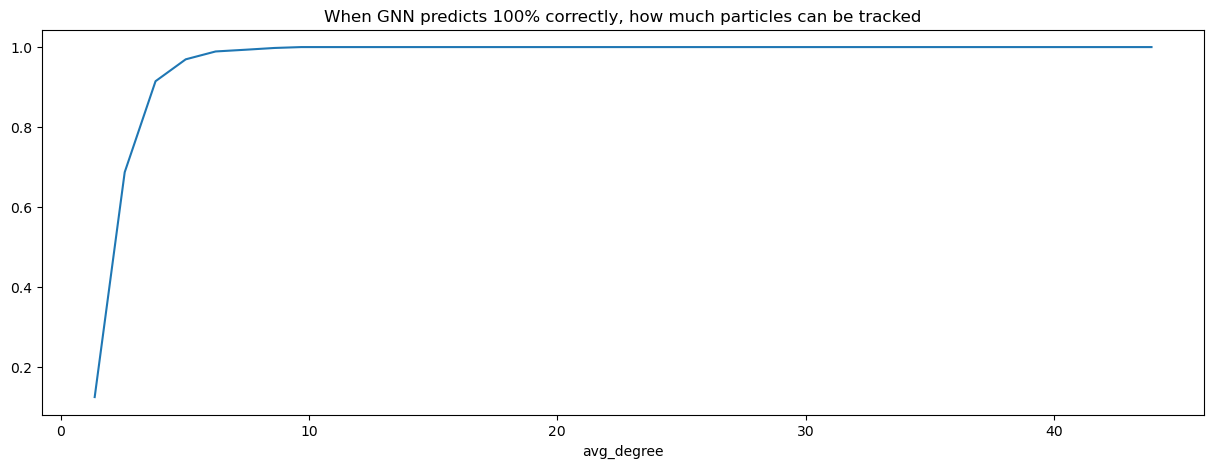

In [4]:
rs.to_frame('coverage').reset_index().groupby('degree').mean().reset_index().set_index('avg_degree')['coverage'].plot(
    title = 'When GNN predicts 100% correctly, how much particles can be tracked',
figsize = (15,5))

In [17]:
rs.to_frame('coverage').reset_index().groupby('degree').mean().reset_index()[['degree','avg_degree','coverage']]

,degree,avg_degree,coverage
0,1,1.366368,0.095055
1,2,2.579900,0.657127
2,3,3.799610,0.900385
3,4,5.023902,0.962654
4,5,6.230629,0.978300
5,6,7.431120,0.986241
6,7,8.568534,0.991194
7,8,9.619770,0.994418
8,9,10.585734,0.996934
9,10,11.520166,0.997563


### Graph Construction

In [1]:
%%time
from libs.basic import *
import gc
pd.set_option("display.max_columns", 100)
PATH_DATA = './data/00.01'
RANDOM_SEED =0
np.random.seed(RANDOM_SEED)

must_not_be_test = [6586, 5115, 7312, 9630, 9008, 7793, 4595, 3393]
def delta_phi(phi1, phi2):
    delta_phi = phi2-phi1
    return np.arctan2(np.sin(delta_phi), np.cos(delta_phi))  
zero_removal = True
pT_min = 2.0
path = os.path.join(PATH_DATA,'trackml','truth_hits',f'truth_hits_{"filtered" if zero_removal else "unfiltered"}_pT_gt_{pT_min}.parquet')
hts = pd.read_parquet(path).set_index(['event','hit_id'])#[['particle_id','x','y','z','r','eta','phi','r_xy']]
hts['blacklist']=False
blacklist_hits = pd.read_parquet(os.path.join(PATH_DATA,'trackml','blacklist_training','blacklist_hits.parquet'))
blacklist_particles = pd.read_parquet(os.path.join(PATH_DATA,'trackml','blacklist_training','blacklist_particles.parquet'))
hts.loc[hts.index.intersection(blacklist_hits.set_index(['event','hit_id']).index),'blacklist']=True
hts = hts.reset_index().set_index(['event','particle_id'])
hts.loc[hts.index.intersection(blacklist_particles.set_index(list(blacklist_particles.columns)).index),'blacklist']=True
hts = hts.reset_index()
hts = hts[~hts['blacklist'].values]

Using device: cuda
CPU times: total: 28.5 s
Wall time: 38.6 s


In [2]:
from sklearn.model_selection import train_test_split
np.random.seed(RANDOM_SEED)  
events_train, events_test = train_test_split(np.sort(hts.reset_index()['event'].unique()), test_size=0.2, random_state=RANDOM_SEED)
events_train, events_val = train_test_split(events_train, test_size=0.2, random_state=RANDOM_SEED)
assert len(np.intersect1d(must_not_be_test,events_val))==0
assert len(np.intersect1d(must_not_be_test,events_test))==0


In [15]:
def f(event, ph, deg):
    import warnings
    warnings.filterwarnings('ignore')
    gc.collect()
    nodes = ph[['hit_id','r','phi','z','particle_id']].sort_values('hit_id').reset_index(drop = True)
    df = pd.read_parquet(os.path.join(PATH_DATA, 'link_candidates',str(event)+'.parquet'))
    df = df[df['hit_id_1']!=df['hit_id_2']].reset_index(drop = True)
    df =df.groupby('hit_id_1').apply(lambda x: x.loc[x['pred'].nlargest(deg).index]).reset_index(level = -1, drop = True)
    
    edges = df[['hit_id_1','hit_id_2','y']].reset_index(drop = True)
    edges = pd.concat([edges,edges.rename({'hit_id_1':'hit_id_2','hit_id_2':'hit_id_1'}, axis = 1)]).drop_duplicates()
    
    cols = ['hit_id','particle_id','r','phi','z','eta']
    edges = pd.merge(pd.merge(edges, ph[cols].rename({i: i+'_1' for i in cols}, axis = 1),
            on = 'hit_id_1', how = 'left'),
            ph[cols].rename({i: i+'_2' for i in cols}, axis = 1),
            on = 'hit_id_2', how = 'left')
    edges['Dr']=edges['r_2']-edges['r_1']
    edges['Dphi']=delta_phi(edges['phi_1'],edges['phi_2'])
    edges['Dz']=edges['z_2']-edges['z_1']
    edges['DR']=np.sqrt((edges['eta_2']-edges['eta_1'])**2+(edges['Dphi']**2))
    edges = edges[['hit_id_1','hit_id_2','y','Dr','Dphi','Dz','DR']].sort_values(['hit_id_1','hit_id_2'])
    x = torch.tensor(nodes[['r','phi','z']].values, dtype = torch.float32)
    x = (x-x.mean(axis =0))/x.std(axis= 0)
    edge_attr = torch.tensor(edges[['Dr','Dphi','Dz','DR']].values, dtype = torch.float32)
    edge_attr = (edge_attr-edge_attr.mean(axis =0))/edge_attr.std(axis =0)
    edge_index = pd.concat([edges['hit_id_1'].map({v:k for k,v in nodes['hit_id'].items()}),
           edges['hit_id_2'].map({v:k for k,v in nodes['hit_id'].items()})], axis = 1)
    edge_index = torch.tensor(edge_index.values.T, dtype=torch.long)
    gc.collect()
    data = pyg.data.Data(x = x,edge_index = edge_index,edge_attr = edge_attr,
                                y = torch.tensor(edges[['y']].values, dtype = torch.float32),
                                hit_ids = torch.tensor(nodes['hit_id'].values, dtype = torch.long),
                                particle_ids = torch.tensor(nodes['particle_id'].values, dtype = torch.long),) 
    th.save(data, os.path.join(PATH_DATA, 'graphs','max_prob_'+str(deg),'events', str(event)+'.pt'))
    
for deg in [10]:
    os.makedirs(os.path.join(PATH_DATA, 'graphs','max_prob_'+str(deg),'events'), exist_ok = True)
    # Parallel(n_jobs = 24)(delayed(f)(event, ph, deg) for event, ph in tqdm(list(hts.groupby('event'))[:]))
    graphs = pd.Series({event: torch.load(os.path.join(PATH_DATA, 'graphs','max_prob_'+str(deg),'events', str(event)+'.pt'),
                               weights_only = False) for event, ph in tqdm(hts.groupby('event'))})

    path = os.path.join(PATH_DATA, 'graphs')
    os.makedirs(os.path.join(path, 'max_prob_'+str(deg)), exist_ok=True)
    graphs.to_pickle(os.path.join(path, 'max_prob_'+str(deg),'graphs_all.pkl'))
    
    
    train_graphs = graphs.loc[np.sort(events_train)]
    val_graphs = graphs.loc[np.sort(events_val)]
    test_graphs = graphs.loc[np.sort(events_test)]
    train_loader = pyg.loader.DataLoader(train_graphs.tolist(), batch_size=32, shuffle=True)
    val_loader = pyg.loader.DataLoader(val_graphs.tolist(), batch_size=32, shuffle=False)
    test_loader = pyg.loader.DataLoader(test_graphs.tolist(), batch_size=32, shuffle=False)
    
    train_graphs.to_pickle(os.path.join(path, 'max_prob_'+str(deg),'graphs_train.pkl'))
    val_graphs.to_pickle(os.path.join(path, 'max_prob_'+str(deg),'graphs_val.pkl'))
    test_graphs.to_pickle(os.path.join(path, 'max_prob_'+str(deg),'graphs_test.pkl'))
    torch.save(train_loader,os.path.join(path, 'max_prob_'+str(deg),'loader_train.pt'))
    torch.save(val_loader,os.path.join(path, 'max_prob_'+str(deg),'loader_val.pt'))
    torch.save(test_loader,os.path.join(path, 'max_prob_'+str(deg),'loader_test.pt'))



    
    np.random.seed(RANDOM_SEED)  
    subevents_train=np.sort(np.random.choice(events_train, len(events_train)//20)).tolist()
    subevents_val=np.sort(np.random.choice(events_val, len(events_val)//20)).tolist()
    subevents_test=np.sort(np.random.choice(events_test, len(events_test)//20)).tolist()

    path = os.path.join(PATH_DATA, 'graphs','max_prob_'+str(deg)+'_subsample_0.05')
    os.makedirs(path, exist_ok=True)
    graphs.to_pickle(os.path.join(path,'graphs_all.pkl'))
       

    
    train_graphs = graphs.loc[np.sort(subevents_train)]
    val_graphs = graphs.loc[np.sort(subevents_val)]
    test_graphs = graphs.loc[np.sort(subevents_test)]
    
    train_loader = pyg.loader.DataLoader(train_graphs.tolist(), batch_size=32, shuffle=True)
    val_loader = pyg.loader.DataLoader(val_graphs.tolist(), batch_size=32, shuffle=False)
    test_loader = pyg.loader.DataLoader(test_graphs.tolist(), batch_size=32, shuffle=False)
    
    train_graphs.to_pickle(os.path.join(path,'graphs_train.pkl'))
    val_graphs.to_pickle(os.path.join(path,'graphs_val.pkl'))
    test_graphs.to_pickle(os.path.join(path,'graphs_test.pkl'))
    torch.save(train_loader,os.path.join(path,'loader_train.pt'))
    torch.save(val_loader,os.path.join(path,'loader_val.pt'))
    torch.save(test_loader,os.path.join(path,'loader_test.pt'))


    np.random.seed(RANDOM_SEED)  
    subevents_train=np.sort(np.random.choice(events_train, len(events_train)//10)).tolist()
    subevents_val=np.sort(np.random.choice(events_val, len(events_val)//10)).tolist()
    subevents_test=np.sort(np.random.choice(events_test, len(events_test)//10)).tolist()

    path = os.path.join(PATH_DATA, 'graphs','max_prob_'+str(deg)+'_subsample_0.1')
    os.makedirs(path, exist_ok=True)
    graphs.to_pickle(os.path.join(path,'graphs_all.pkl'))
       

    
    train_graphs = graphs.loc[np.sort(subevents_train)]
    val_graphs = graphs.loc[np.sort(subevents_val)]
    test_graphs = graphs.loc[np.sort(subevents_test)]
    
    train_loader = pyg.loader.DataLoader(train_graphs.tolist(), batch_size=32, shuffle=True)
    val_loader = pyg.loader.DataLoader(val_graphs.tolist(), batch_size=32, shuffle=False)
    test_loader = pyg.loader.DataLoader(test_graphs.tolist(), batch_size=32, shuffle=False)
    
    train_graphs.to_pickle(os.path.join(path,'graphs_train.pkl'))
    val_graphs.to_pickle(os.path.join(path,'graphs_val.pkl'))
    test_graphs.to_pickle(os.path.join(path,'graphs_test.pkl'))
    torch.save(train_loader,os.path.join(path,'loader_train.pt'))
    torch.save(val_loader,os.path.join(path,'loader_val.pt'))
    torch.save(test_loader,os.path.join(path,'loader_test.pt'))

  0%|          | 0/8850 [00:00<?, ?it/s]

# DBSCAN

In [39]:
from libs.basic import *
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
pd.set_option("display.max_columns", 100)
PATH_DATA = './data/00.01'
RANDOM_SEED =0
np.random.seed(RANDOM_SEED)

In [40]:
zero_removal = True
pT_min = 2.0
path = os.path.join(PATH_DATA,'trackml','truth_hits',f'truth_hits_{"filtered" if zero_removal else "unfiltered"}_pT_gt_{pT_min}.parquet')
hts = pd.read_parquet(path).set_index(['event','hit_id'])#[['particle_id','x','y','z','r','eta','phi','r_xy']]
blacklist_hits = pd.read_parquet(os.path.join(PATH_DATA,'trackml','blacklist_training','blacklist_hits.parquet'))
blacklist_particles = pd.read_parquet(os.path.join(PATH_DATA,'trackml','blacklist_training','blacklist_particles.parquet'))
hts = hts.drop(blacklist_hits.set_index(['event','hit_id']).index.intersection(hts.index), errors='ignore')
hts = hts.reset_index().set_index(['event','particle_id'])
hts = hts.drop(hts.index.intersection(blacklist_particles.set_index(['event','particle_id']).index))
hts = hts.reset_index().set_index(['event','hit_id'])
hts = hts[['particle_id','eta','phi']]

In [41]:
def delta_phi(phi1, phi2):
    delta = phi2 - phi1
    return np.arctan2(np.sin(delta), np.cos(delta))

def eta_phi_distance(u, v):
    eta_diff = u[0] - v[0]
    phi_diff = delta_phi(u[1], v[1])
    return np.sqrt(eta_diff**2 + phi_diff**2)  # 또는 eta_diff**2 + phi_diff**2 등

In [4]:
def f(event, rows):
    rs, rs2 = dict(),dict()
    X = rows[['eta','phi']].values
    dist_matrix = pairwise_distances(X, metric=eta_phi_distance)
    for eps in np.linspace(0,0.1, 11).tolist()[1:-1]+np.linspace(0,1.0, 11).tolist()[1:]:
        db = DBSCAN(eps=eps, min_samples=5, metric='precomputed')
        rows['cluster'] = db.fit_predict(dist_matrix)
        rows.loc[rows['cluster']==-1, 'cluster']= rows['cluster'].max()+np.arange(rows[rows['cluster']==-1].shape[0])
        rs[(event,eps)] = rows.groupby('particle_id')['cluster'].nunique()    
        
        cluster_sizes = rows['cluster'].value_counts().values
        total_edges = sum((k * (k - 1)) // 2 for k in cluster_sizes)
        rs2[(event, eps)]=avg_degree = 2 * total_edges / len(rows)
        
    rs = pd.Series(rs)
    rs2 = pd.Series(rs2)
    return rs, rs2
rs = Parallel(n_jobs = 16)(delayed(f)(event,rows) for event, rows in tqdm(list(hts.reset_index().groupby('event'))[:50]))
efficiency = pd.concat([pd.concat(i[0].to_dict()) for i in rs])
efficiency = 1-efficiency[efficiency>1].groupby(level = 1).sum()/efficiency.groupby(level = 1).sum()
avg_degree= pd.concat([i[1] for i in rs]).groupby(level =1).mean()

  0%|          | 0/50 [00:00<?, ?it/s]

<Axes: xlabel='avg_degree'>

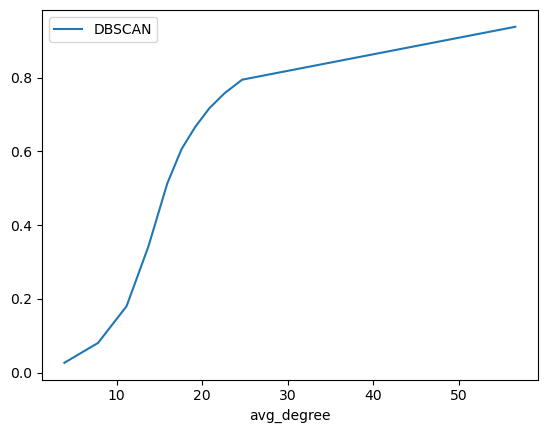

In [5]:
eff_deg_dbscan = pd.concat([efficiency.fillna(1), avg_degree], axis = 1, keys = ['efficiency','avg_degree'])
os.makedirs(os.path.join(PATH_DATA, 'efficiency_degree'), exist_ok = True)
eff_deg_dbscan.to_pickle(os.path.join(PATH_DATA, 'efficiency_degree','eff_deg_dbscan.pkl'))
eff_deg_dbscan.iloc[:11].plot(x = 'avg_degree', y='efficiency', label = 'DBSCAN')

In [43]:
eff_deg_maxProb=pd.read_pickle(os.path.join(PATH_DATA, 'efficiency_degree','eff_deg_maxProb.pkl'))
eff = eff_deg_maxProb.groupby('degree').mean()
deg = eff_deg_maxProb.reset_index().groupby(['degree','event']).first()
deg['temp']=deg['avg_degree']*deg['n_nodes']
deg = deg.groupby('degree')[['temp','n_nodes']].sum()
deg['avg_degree']=deg['temp']/deg['n_nodes']
eff_deg_maxProb=pd.concat([eff, deg['avg_degree']], keys=['efficiency','avg_degree'], axis= 1)
eff_deg_dbscan=pd.read_pickle(os.path.join(PATH_DATA, 'efficiency_degree','eff_deg_dbscan.pkl'))

Text(0, 0.5, 'Efficiency')

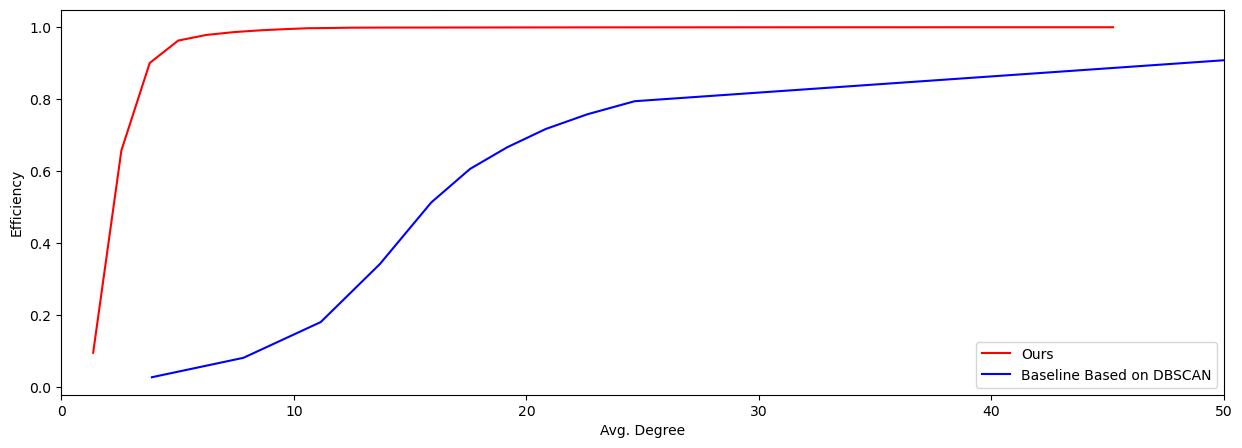

In [47]:

ax = eff_deg_maxProb.plot(x = 'avg_degree', y = 'efficiency', label = 'Ours',color = 'red')
eff_deg_dbscan.plot(x = 'avg_degree', y = 'efficiency', ax = ax, label = 'Baseline Based on DBSCAN', color = 'blue', 
                    # title = '(Max # of Particles that can be tracked)/(# of Particles)'
                    figsize = (15,5)
                   )
ax.set_xlim(0, 50)
plt.xlabel('Avg. Degree')
plt.ylabel('Efficiency')

In [21]:
1-eff_deg_maxProb.loc[eff_deg_maxProb['efficiency']>=0.99,'avg_degree'].iloc[0]/\
eff_deg_dbscan.loc[eff_deg_dbscan['efficiency']>=0.99,'avg_degree'].iloc[0]

np.float64(0.9898824089035042)

In [11]:
eff_deg_maxProb

,efficiency,avg_degree
degree,,
1,0.095055,1.366264
2,0.657127,2.579886
3,0.900385,3.799520
4,0.962654,5.023782
5,0.978300,6.230512
6,0.986241,7.431057
7,0.991194,8.568539
8,0.994418,9.619787
9,0.996934,10.585696


(0.0, 50.0)

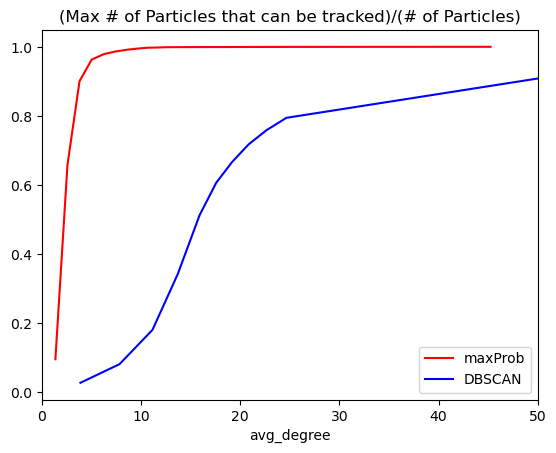

In [35]:
ax = eff_deg_maxProb.plot(x = 'avg_degree', y = 'efficiency', label = 'maxProb',color = 'red')
eff_deg_dbscan.plot(x = 'avg_degree', y = 'efficiency', ax = ax, label = 'DBSCAN', color = 'blue', 
                    title = '(Max # of Particles that can be tracked)/(# of Particles)')
ax.set_xlim(0, 50)

,efficiency,avg_degree
degree,,
1,0.095055,1.366264
2,0.657127,2.579886
3,0.900385,3.799520
4,0.962654,5.023782
5,0.978300,6.230512
6,0.986241,7.431057
7,0.991194,8.568539
8,0.994418,9.619787
9,0.996934,10.585696
